# RateAndHalfSat - extended
Nutrient comparisons with edited dataset using surface instead of 2m for depth. (

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools, nc_tools
import pytz
import os
import glob
import matplotlib.cm as cm
import matplotlib.patches as patches
import scipy.io as sio
%matplotlib inline

In [2]:
plt.style.use('/ocean/vdo/MEOPAR/biomodelevalpaper/bioModelEvalPaper.mplstyle')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
#load model grid stuff
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [5]:
# Load CitSci data and clean it up
nutrients_2015 = pd.read_csv(
    '/ocean/eolson/MEOPAR/obs/PSFCitSci/PSFbottledata2015_CN_edits_EOCor2.csv')
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, 
                                                    land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])
nutrients_2015 = nutrients_2015[~nutrients_2015.flagged]

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [6]:
local = pytz.timezone ("America/Los_Angeles")

In [7]:
model_nutrients = sorted(glob.glob('/data/vdo/MEOPAR/completed-runs/RateAndHalfSat/test*/SalishSea*1d*ptrc*'))

In [8]:
with nc_tools.scDataset(model_nutrients) as f: #takes a while to run, prone to killing kernal
    times = f.variables['time_counter'][:]
    print('times is done')
    model_si = f.variables['silicon'][:, :19, ...]
    print('Si is done')
    model_n023 = f.variables['nitrate'][:, :19, ...]
    print('Nitrate is done')

times is done
Si is done
Nitrate is done


In [9]:
model_nutrientsb = sorted(glob.glob(
    '/data/vdo/MEOPAR/completed-runs/RateAndHalfSat/test*/SalishSea*1d*grid_T*'))

In [10]:
with nc_tools.scDataset(model_nutrientsb) as f: #takes a while to run, prone to killing kernal
    model_sal = f.variables['vosaline'][:, :19, ...]
    print('sal is done')

sal is done


In [11]:
h = nc.Dataset(model_nutrients[0])

In [12]:
# convert into datetime
converted_timesa = nc.num2date(times, h.variables['time_counter'].units)

In [13]:
converted_timesa[0]

datetime.datetime(2015, 2, 1, 12, 0)

In [14]:
converted_timesa[-1]

datetime.datetime(2015, 10, 8, 12, 0)

In [15]:
nutrients_2015 = nutrients_2015.dropna(subset = ['Time'])
nutrients_2015.shape

(838, 13)

In [16]:
# mask everything outside of daterange of modelled results 
# apply same mask to everything in CS data
dates = nutrients_2015['date'].values
dates = np.array([pd.to_datetime(dates[n]) for n in range(838)])
dates = np.ma.masked_outside(dates, converted_timesa[0], converted_timesa[-1])
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates.mask)
stations = np.ma.masked_array(nutrients_2015['station'].values, mask = dates.mask)

In [17]:
list_of_datetimes = np.array([datetime.datetime(1900,1,1) + datetime.timedelta(hours = n) 
                                    for n in range(838)])
t = 0
for n in nutrients_2015.index:
    if dates.mask[t] == False: 
        date = (local.localize(pd.to_datetime(datetime.datetime.strptime(nutrients_2015['date'][n] 
                               +' '+ nutrients_2015['Time'][n], 
                               '%d-%m-%Y %I:%M:%S %p')), 
                       is_dst=True).astimezone(pytz.utc))
        list_of_datetimes[t] = date
    t = t + 1

In [18]:
np.ma.count(cs_si)

751

In [19]:
list_of_model_si = np.ma.masked_array(np.zeros((838)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((838)), mask = True)
list_of_model_sal = np.ma.masked_array(np.zeros((838)), mask = True)
t = 0
for n in range(838):
    if dates.mask[n] == False:
        Yind = int(Yinds[n])
        Xind = int(Xinds[n])
        date = dates[n]
        if ((depths[n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
            index = np.argmin(np.abs(converted_timesa - date))
            s_val = model_si[index, 18,Yind, Xind]
            n_val = model_n023[index, 18, Yind, Xind]
            sal_val = model_sal[index, 18,Yind, Xind]
            list_of_model_sal.mask[t] = False
            list_of_model_sal[t] = sal_val
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
        if ((depths[n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
            index = np.argmin(np.abs(converted_timesa - date))
            s_val = model_si[index, 0,Yind, Xind]
            n_val = model_n023[index, 0, Yind, Xind]
            sal_val = model_sal[index, 0,Yind, Xind]
            list_of_model_sal.mask[t] = False
            list_of_model_sal[t] = sal_val
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
    t = t + 1

In [20]:
list_of_datetimes = np.ma.masked_array(list_of_datetimes, mask = list_of_model_ni.mask)
np.ma.count(list_of_datetimes)

742

In [21]:
cs_no23.mask = list_of_model_ni.mask
cs_si.mask = list_of_model_si.mask

In [22]:
np.ma.count(cs_no23)

742

In [23]:
np.ma.count(list_of_model_ni)

742

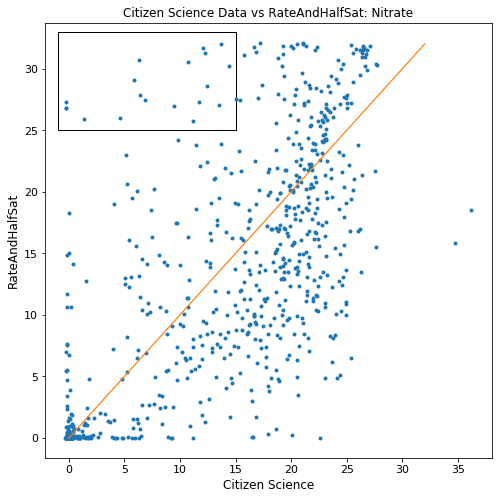

In [24]:
fig, ax = plt.subplots(figsize = (8,8))
colours = cm.rainbow(np.linspace(0,1,8))
ax.plot(cs_no23, list_of_model_ni, '.')

ax.plot(np.arange(0,33), np.arange(0,33), '-')
ax.set_title('Citizen Science Data vs RateAndHalfSat: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('RateAndHalfSat')
ax.add_patch(
    patches.Rectangle(
        (-1, 25),   # (x,y)
        16,          # width
        8,          # height
    fill = False)
);

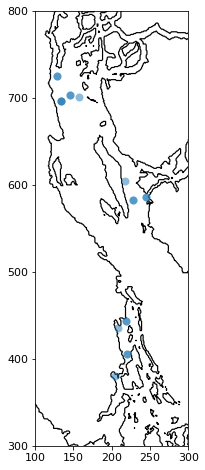

In [25]:
fig, ax = plt.subplots(figsize = ((12,8)))
ax.plot(Xinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 
        Yinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 'o', alpha = 0.5)
viz_tools.set_aspect(ax)
ax.set_xlim(100, 300)
ax.set_ylim(300, 800)
viz_tools.plot_coastline(ax, grid);

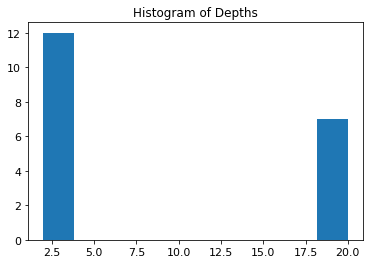

In [26]:
plt.hist(depths[(cs_no23 <= 15) & (list_of_model_ni >= 25)]);
plt.title('Histogram of Depths');

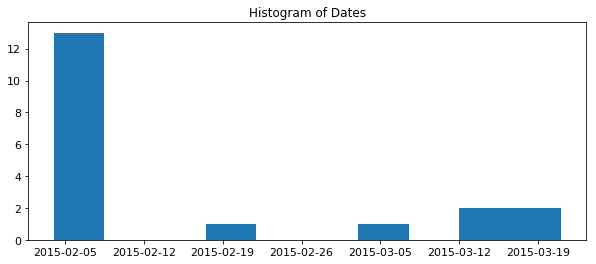

In [27]:
fig, ax = plt.subplots(figsize = (10,4))
ax.hist(dates[[(cs_no23 <= 15) & (list_of_model_ni >= 25)]])
ax.set_title('Histogram of Dates');

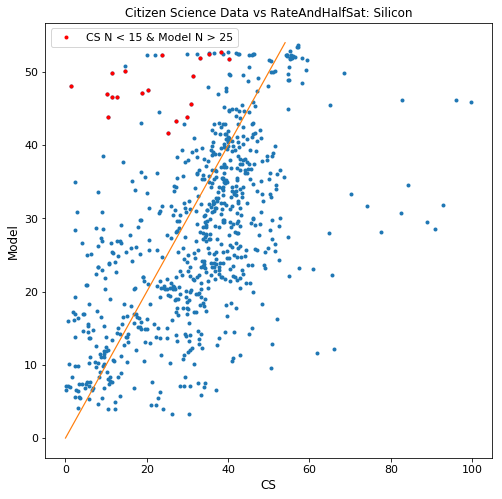

In [28]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, '.');
ax.plot(np.arange(0,55), np.arange(0,55), '-')
ax.plot(cs_si[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 
        list_of_model_si[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 'r.', label = 'CS N < 15 & Model N > 25')
ax.legend()
ax.set_title('Citizen Science Data vs RateAndHalfSat: Silicon')
ax.set_xlabel('CS')
ax.set_ylabel('Model');

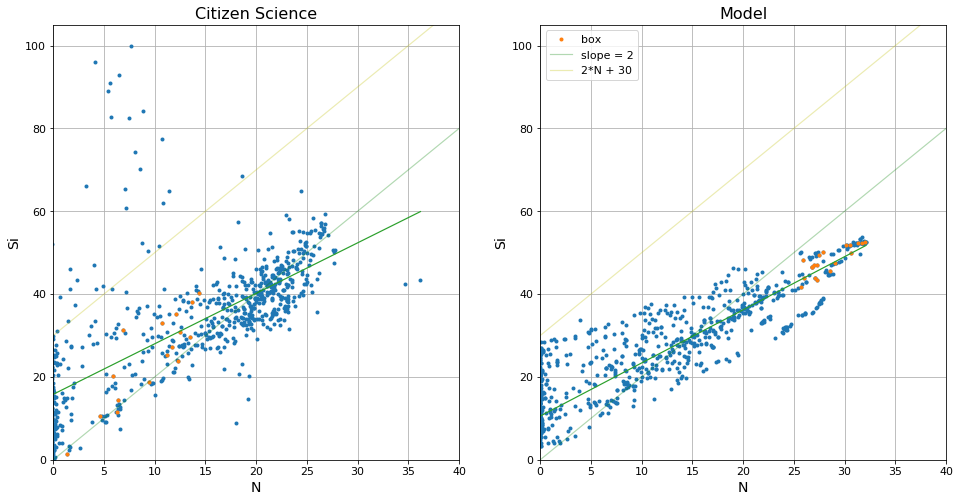

In [29]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_no23, cs_si, '.')
ax[0].plot(cs_no23[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 
           cs_si[(cs_no23 <= 15) & (list_of_model_ni >= 25)], '.')
ax[0].plot(np.unique(cs_no23), np.poly1d(np.polyfit(cs_no23, cs_si, 1))(np.unique(cs_no23)))
x = np.arange(0,50)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)

ax[1].plot(list_of_model_ni, list_of_model_si, '.')
ax[1].plot(list_of_model_ni[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 
           list_of_model_si[(cs_no23 <= 15) & (list_of_model_ni >= 25)], '.', label = 'box')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')

ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [30]:
ctd_2015 = sio.loadmat('/ocean/rich/home/metro/venus_adcp/matlabPSF/CitSci_Final.mat')
ctd_data = ctd_2015[list(ctd_2015.keys())[3]]
ctd_dtype = ctd_data.dtype
ctddata = {n: ctd_data[n][0, 0] for n in ctd_dtype.names}
ctd_times = ctd_data['mtime'][0,0][0,:]
ctd_temps = ctd_data['temp'][0,0][:,:]
ctd_sals = ctd_data['sal'][0,0][:,:]
ctd_depths = ctd_data['depth'][0,0][:,:]
ctd_lons = ctd_data['long'][0,0][0,:]
ctd_lats = ctd_data['lat'][0,0][0,:]
base = datetime.datetime(2000, 1, 1)
py_ctd_times = np.array([base for i in range(2142)])
for n in range(2142):
    py_ctd_times[n] = ((datetime.datetime.fromordinal(int(ctd_times[n])))
                       + datetime.timedelta(days=ctd_times[n]%1)
                       - datetime.timedelta(days = 366))
py_ctd_days = np.array([py_ctd_times[n].date() for n in range(2142)])
py_ctd_hours = np.array([py_ctd_times[n].hour for n in range(2142)])
surface_depths = ctd_depths[0,...]
deeper_depths = ctd_depths[19,...]
surface_depths = surface_depths[(py_ctd_times > converted_timesa[0]) & (py_ctd_times < converted_timesa[-1])]
surface_sals = ctd_sals[0,...][(py_ctd_times > converted_timesa[0]) & (py_ctd_times < converted_timesa[-1])]
py_ctd_times2 = py_ctd_times[(py_ctd_times > converted_timesa[0]) & (py_ctd_times < converted_timesa[-1])]
ctd_Yinds = np.array([])
ctd_Xinds = np.array([])
for n in range(2142):
    Yind, Xind = geo_tools.find_closest_model_point(ctd_lons[n], 
                                                    ctd_lats[n], 
                                                    X, Y, 
                                                    land_mask = bathy.mask)
    ctd_Yinds = np.append(ctd_Yinds, Yind)
    ctd_Xinds = np.append(ctd_Xinds, Xind)
ctd_Yinds2 = ctd_Yinds[(py_ctd_times > converted_timesa[0]) & (py_ctd_times < converted_timesa[-1])]
ctd_Xinds2 = ctd_Xinds[(py_ctd_times > converted_timesa[0]) & (py_ctd_times < converted_timesa[-1])]

In [31]:
ctd_Yinds2.shape

(2142,)

In [32]:
list_of_model_sal = np.ma.masked_array(np.zeros((2142)), mask = True)
for n in range(2142):
    if surface_depths[n] == 1:
        Yind = int(ctd_Yinds2[n])
        Xind = int(ctd_Xinds2[n])
        date = py_ctd_times2[n]
        if mesh.variables['tmask'][0,0,Yind,Xind] == 1:
            index = np.argmin(np.abs(converted_timesa - date))
            sal_val = model_sal[index, 0, Yind, Xind]
            list_of_model_sal.mask[n] = False
            list_of_model_sal[n] = sal_val

In [33]:
np.ma.count(list_of_model_sal)

2105

In [34]:
surface_sals2 = np.ma.masked_array(surface_sals, mask = list_of_model_sal.mask)

In [35]:
py_ctd_days2 = np.ma.masked_array(py_ctd_days[(py_ctd_times > converted_timesa[0]) & 
                                              (py_ctd_times < converted_timesa[-1])], 
                                  mask = list_of_model_sal.mask)

In [36]:
py_ctd_datetimes = np.ma.masked_array([datetime.datetime(2000,1,1) + datetime.timedelta(hours=i) 
                                       for i in range(2142)], mask = True)
for n in range(2142):
    if py_ctd_days2.mask[n] == False:
        py_ctd_datetimes.mask[n] == False 
        py_ctd_datetimes[n] = datetime.datetime(py_ctd_days2[n].year, 
                                                    py_ctd_days2[n].month, py_ctd_days2[n].day)

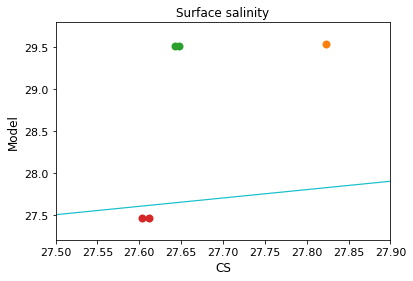

In [37]:
for n in range(19):
    plt.plot(surface_sals2[(ctd_Yinds2 == Yinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                           (ctd_Xinds2 == Xinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                           (py_ctd_datetimes == dates[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n])],
            list_of_model_sal[(ctd_Yinds2 == Yinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                              (ctd_Xinds2 == Xinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                              (py_ctd_datetimes == dates[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n])], 'o',
            label = str(n))
plt.plot(np.arange(27,29), np.arange(27,29))
plt.ylim(27.2, 29.8)
plt.xlabel('CS')
plt.ylabel('Model')
plt.title('Surface salinity')
plt.xlim(27.5,27.9);
#plt.axis('equal');

In [38]:
for n in range(19):
    print(n, 
          Yinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n],
          Xinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n],
          dates[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n])

0 725.0 129.0 2015-02-19 00:00:00
1 697.0 134.0 2015-03-13 00:00:00
2 703.0 145.0 2015-03-13 00:00:00
3 697.0 134.0 2015-03-18 00:00:00
4 583.0 228.0 2015-03-21 00:00:00
5 586.0 245.0 2015-02-04 00:00:00
6 586.0 245.0 2015-02-04 00:00:00
7 604.0 217.0 2015-02-04 00:00:00
8 583.0 228.0 2015-02-04 00:00:00
9 697.0 134.0 2015-02-04 00:00:00
10 703.0 145.0 2015-02-04 00:00:00
11 701.0 157.0 2015-02-04 00:00:00
12 725.0 129.0 2015-02-07 00:00:00
13 435.0 208.0 2015-02-07 00:00:00
14 443.0 219.0 2015-02-07 00:00:00
15 443.0 219.0 2015-02-07 00:00:00
16 406.0 220.0 2015-02-07 00:00:00
17 406.0 220.0 2015-02-07 00:00:00
18 380.0 204.0 2015-03-07 00:00:00


In [39]:
for n in range(19):
    print(n, 
          surface_sals2[(ctd_Yinds2 == Yinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                        (ctd_Xinds2 == Xinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                        (py_ctd_datetimes == dates[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n])].shape[0])

0 0
1 1
2 2
3 2
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0


In [40]:
list_of_deep_model_sal = np.ma.masked_array(np.zeros((2142)), mask = True)
list_of_deep_cs_sal = np.array([])
for n in range(2142):
    Yind = int(ctd_Yinds2[n])
    Xind = int(ctd_Xinds2[n])
    date = py_ctd_times2[n]
    if ctd_depths[19, n] == 20:
        list_of_deep_cs_sal = np.append(list_of_deep_cs_sal, ctd_sals[19,n])
    elif ctd_depths[18, n] == 20:
        list_of_deep_cs_sal = np.append(list_of_deep_cs_sal, ctd_sals[18,n])
    elif ctd_depths[17, n] == 20:
        list_of_deep_cs_sal = np.append(list_of_deep_cs_sal, ctd_sals[17,n])
    elif ctd_depths[16, n] == 20:
        list_of_deep_cs_sal = np.append(list_of_deep_cs_sal, ctd_sals[16,n])
    else:
        list_of_deep_cs_sal = np.append(list_of_deep_cs_sal, np.NaN)
    if mesh.variables['tmask'][0,18,Yind,Xind] == 1:
        index = np.argmin(np.abs(converted_timesa - date))
        sal_val = model_sal[index, 18, Yind, Xind]
        list_of_deep_model_sal.mask[n] = False
        list_of_deep_model_sal[n] = sal_val

In [41]:
ctd_depths.shape

(400, 2142)

In [42]:
np.ma.count(list_of_deep_model_sal)

2072

In [43]:
list_of_deep_cs_sal2 = np.ma.masked_array(list_of_deep_cs_sal, mask = list_of_deep_model_sal.mask)

In [44]:
list_of_deep_cs_sal3 = np.ma.masked_invalid(list_of_deep_cs_sal2)
list_of_deep_model_sal2 = np.ma.masked_array(list_of_deep_model_sal, mask = list_of_deep_cs_sal3.mask)
print(np.ma.count(list_of_deep_cs_sal3), np.ma.count(list_of_deep_model_sal2))

1988 1988


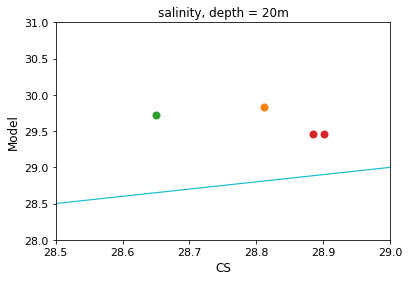

In [45]:
for n in range(19):
    plt.plot(list_of_deep_cs_sal3[(ctd_Yinds2 == Yinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                           (ctd_Xinds2 == Xinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                           (py_ctd_datetimes == dates[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n])],
            list_of_deep_model_sal2[(ctd_Yinds2 == Yinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                              (ctd_Xinds2 == Xinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n]) &
                              (py_ctd_datetimes == dates[(cs_no23 <= 15) & (list_of_model_ni >= 25)][n])], 'o',
            label = str(n))
plt.plot(np.arange(27,31), np.arange(27,31))
plt.ylim(28, 31)
plt.xlabel('CS')
plt.ylabel('Model')
plt.title('salinity, depth = 20m')
plt.xlim(28.5,29);
#plt.axis('equal');

bias =  0.04191367913997368
RMSE = 0.5257055454218144
Willmott = 0.8706633195914795


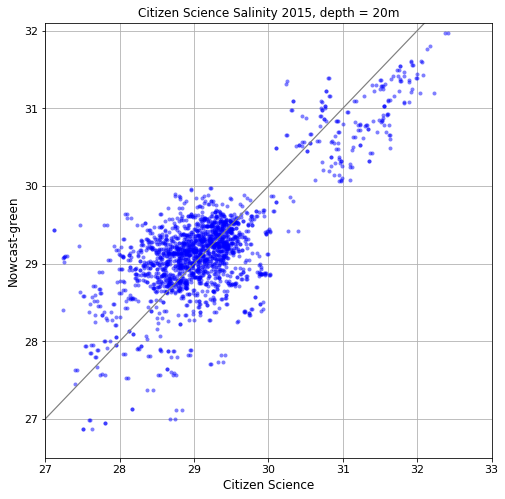

In [46]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(list_of_deep_cs_sal3, list_of_deep_model_sal2,  'b.', alpha = 0.5)
ax.plot(np.arange(25,35),np.arange(25,35), color = 'grey')
ax.set_ylim(26.5, 32.1)
ax.set_xlim(27, 33)
ax.grid('on')
ax.set_title('Citizen Science Salinity 2015, depth = 20m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(list_of_deep_cs_sal3) + np.mean(list_of_deep_model_sal2)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_deep_model_sal2 - list_of_deep_cs_sal3)**2) /
                              np.ma.count(list_of_deep_cs_sal3))))
xbar = np.mean(list_of_deep_cs_sal3)
print('Willmott = ' + str(1-(np.sum((list_of_deep_model_sal2 - list_of_deep_cs_sal3)**2)  / 
                             np.sum((np.abs(list_of_deep_model_sal2 - xbar) 
                                     + np.abs(list_of_deep_cs_sal3 - xbar))**2))))

bias =  -1.4620288763346316
RMSE = 2.8809834495723425
Willmott = 0.824949676048081


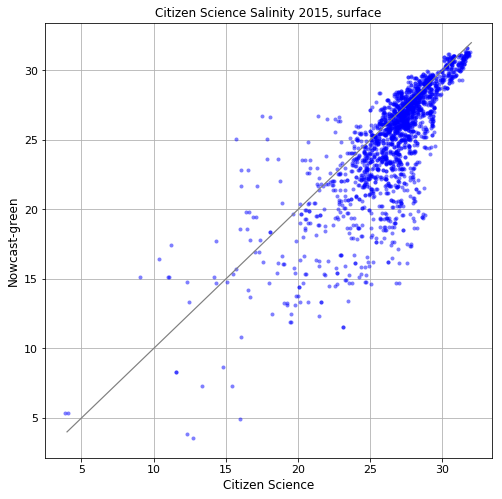

In [47]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(surface_sals2, list_of_model_sal,  'b.', alpha = 0.5)
ax.plot(np.arange(4,33),np.arange(4,33), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Salinity 2015, surface')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(surface_sals2) + np.mean(list_of_model_sal)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_sal - surface_sals2)**2) /
                              np.ma.count(surface_sals2))))
xbar = np.mean(surface_sals2)
print('Willmott = ' + str(1-(np.sum((list_of_model_sal - surface_sals2)**2)  / 
                             np.sum((np.abs(list_of_model_sal - xbar) 
                                     + np.abs(surface_sals2 - xbar))**2))))